<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Соревнование по прогнозированию популярности статьи на портале Medium
## <center> Ridge baseline

[Ссылка](https://mlcourse.arktur.io/) на соревнование.

**Задача** 

Есть выборка статей с популярного англоязычного портала Medium. Задача – спрогнозировать число рекомендаций ("лайков") статьи.
Предлагается Вам самим составить обучающую и тестовую выборки на основе имеющихся данных, обучить модель-регрессор и сформировать файл посылки с прогнозами – числом рекомендаций статей (с `log1p`-преобразованием) из тестовой выборки.

**Данные**

Обучающая выборка – 52699 статей, опубликованных до 2016 года включительно (**train.zip** ~ 480 Mb, unzip ~1.6 Gb). Тестовая выборка – 39492 статьи, опубликованные с 1 января по 27 июня 2017 года (**test.zip** ~425 Mb, unzip ~1.4 Gb).

Данные о статьях представлены в JSON формате с полями:
- _id и url – URL статьи
- published – время публикации
- title – название статьи
- author – имя автора, его акканут на Твиттере и Medium
- content – HTML-контент статьи
meta_tags – остальная информация о статье

В файле **train_log1p_recommends.csv** представлены номера (id) статей из обучающей выборки вместе с целевым показателем: числом рекомендаций статей, к которому применено преобразование `log1p(x) = log(1 + x)` В файле **sample_submission.csv** представлен пример файла посылки.

In [1]:
import os
import json
import pickle
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor

import zlib
import re

In [2]:
PATH_TO_DATA = '../../data/medium'

Следующий код я стащил откуда-то со StackOverflow – он выкидывает из текста HTML-теги.

In [3]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ' '.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Готовим обучающую и тестовую выборки. Забираем из JSON-представления статьи только content (собственно текст статьи), очищаем его от HTML-тегов и записываем в файл. Такой формат подойдет для извлечения признаков (Bag of Words) с помощью `CountVectorizer`. На Mac с SSD это все работает относительно быстро, на Windows без SSD будет скучновато.

In [4]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                        'train_log1p_recommends.csv'), index_col='id')

In [5]:
y_train = train_target['log_recommends'].values

In [6]:
from collections import Counter

In [185]:
def addKV(k, v, meta, t_count):
    if k not in meta:
        meta[k] = k + '_'#str(len(meta)) + '_'
    s = strip_tags(str(v).replace('\n', ' '))
    for i in range(len(s)):
        t_count.update([meta[k] + s[i]])
        if i < len(s) - 1:
            t_count.update([meta[k] + s[i:i+2]])
        if i < len(s) - 2:
            t_count.update([meta[k] + s[i:i+3]])

In [186]:
def nonuniq_words(text):
    return [e.lower() for e in re.findall("\w+", text, re.UNICODE)]

In [234]:
def process_json(json_data, meta):
    t_counter = Counter()
    for k, v in json_data.items():
        if k == 'quality':
            continue
        if isinstance(v, dict):
            for k1, v1 in v.items():
                #print(k, k1, v1)
                addKV(k + '\t' + k1, v1, meta, t_counter)
        else:
            #print(k, v)
            addKV(k, v, meta, t_counter)
    return t_counter

def getFeatures(json_data):
    sc = json_data['content']
    tc = nonuniq_words(sc)

    st = json_data['title']
    tt = nonuniq_words(st)

    return [np.log(1 + len(sc)),
                 np.log(1 + len(tc)),
                 len(set(tc)) / len(tc),
                 len(zlib.compress(sc.encode('utf-8'))) / len(sc.encode('utf-8')),
                 np.log(1 + len(st)),
                 np.log(1 + len(tt)),
                 len(set(tt)) / len(tt),
                 len(zlib.compress(st.encode('utf-8'))) / len(st.encode('utf-8')),
                 int(sc.find('<img') != -1),
                 int(sc.find('.gif') != -1)
                ]

In [5]:
%%time

ngr_dict = dict()
meta = dict()

t_counter_list = []
dt_list = []
X_tr = []
with open(os.path.join(PATH_TO_DATA, 'train.json'), encoding='utf-8') as inp_json_file, \
     open(os.path.join(PATH_TO_DATA, 'train_raw_content.txt'), 'w', encoding='utf-8') \
     as out_raw_text_file:
     
    i = 0
    for line in inp_json_file:
        json_data = json.loads(line)
        print(strip_tags(json_data['content']))
        i += 1
        if i == 2:
            break
        continue
        target = float(json_data['quality']['recommends'])
        dt = json_data['published']['$date'][:7]
        if not dt in ngr_dict:
            ngr_dict[dt] = dict()

        t_counter = process_json(json_data, meta)

        t_counter_list.append(t_counter)
        dt_list.append(dt)
        for ek, ev in t_counter.items():
            if ek not in ngr_dict[dt]:
                ngr_dict[dt][ek] = [0, 0]
            ngr_dict[dt][ek][0] += np.log(1 + ev)
            ngr_dict[dt][ek][1] += y_train[i]            
        i += 1

        features = getFeatures(json_data)
        X_tr.append(features)
        
        if i % 500 == 0:
            print(i)
        if i == 10000:
            break

Medium Blocked Unblock Follow Following Everyone’s stories and ideas Aug 13, 2012 Medium Terms of Service Effective: March 7, 2016 These Terms of Service (“Terms”) are a contract between you and A Medium Corporation. They govern your use of Medium’s sites, services, mobile apps, products, and content (“Services”). By using Medium, you agree to these Terms. If you don’t agree to any of the Terms, you can’t use Medium. We can change these Terms at any time. We keep a  historical  record of all changes to our Terms on GitHub. If a change is material, we’ll let you know before they take effect. By using Medium on or after that effective date, you agree to the new Terms. If you don’t agree to them, you should delete your account before they take effect, otherwise your use of the site and content will be subject to the new Terms. Content rights & responsibilities You own the rights to the content you create and post on Medium. By posting content to Medium, you give us a nonexclusive license 

Medium Blocked Unblock Follow Following Everyone’s stories and ideas Aug 13, 2012 Medium Privacy Policy Effective Date: March 7, 2016 Privacy is important. We respect yours. Our goal is to do more than we have to by law — we want to earn your trust that we are careful with your data. General information This policy sets out our privacy practices and explains how we handle the information we collect when you visit and use our sites, services, mobile applications, products, and content (“Services”). What we may collect We collect information about what Medium pages you access, information about your mobile device (such as device or browser type), information you send us (such as an email address used to register or communicate with us), and referral information. When you use Medium Services, we may collect and store your Internet Protocol address. We may use this information to fight spam and other abuse; to personalize Medium Services; or to generate aggregate, non-identifying informati

In [188]:
ngr_dict_cum = dict()
next_dict = dict()
for e in sorted(ngr_dict.keys()):
    ngr_dict_cum[e] = next_dict.copy()
    
    for k, v in ngr_dict[e].items():
        if k not in next_dict:
            next_dict[k] = [0, 0]
        next_dict[k][0] += v[0]
        next_dict[k][1] += v[1]

In [189]:
print(sorted(ngr_dict_cum.keys()))

['2007-02', '2008-06', '2008-09', '2010-08', '2011-03', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2012-01', '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12', '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12']


In [190]:
len(ngr_dict_cum['2016-12'])

1251261

In [191]:
sorted(ngr_dict_cum['2016-12'].items(), key=lambda x: -(x[1][1] / (x[1][0] + 10)))[:20]

[('content_K 1', [86.50986617736865, 749.11580000000004]),
 ('content_1K ', [72.492771886342481, 620.34753999999987]),
 ('content_.1K', [42.975125194716604, 394.33731000000012]),
 ('content_3K ', [41.588830833596703, 379.04313999999999]),
 ('content_3K', [46.153179025064546, 406.57934]),
 ('content_K 3', [40.60800158058499, 365.47115000000002]),
 ('link_tags\tamphtml_am', [50.599744180876009, 435.07601999999997]),
 ('link_tags\tamphtml_/am', [50.599744180876009, 435.07601999999997]),
 ('link_tags\tamphtml_/p/', [50.599744180876009, 435.07601999999997]),
 ('link_tags\tamphtml_mp', [50.599744180876009, 435.07601999999997]),
 ('link_tags\tamphtml_mp/', [50.599744180876009, 435.07601999999997]),
 ('link_tags\tamphtml_m', [50.599744180876009, 435.07601999999997]),
 ('link_tags\tamphtml_/p', [50.599744180876009, 435.07601999999997]),
 ('link_tags\tamphtml_amp', [50.599744180876009, 435.07601999999997]),
 ('link_tags\tamphtml_p/p', [50.599744180876009, 435.07601999999997]),
 ('content_K 2', [

In [192]:
from scipy.sparse import csr_matrix, hstack

In [193]:
ngr2num = dict(zip(sorted(ngr_dict_cum['2016-12'].keys()), range(len(ngr_dict_cum['2016-12']))))

In [196]:
%%time

row = []
col = []
data = []
i = 0
for t_counter, dt in zip(t_counter_list, dt_list):
    for ek, ev in t_counter.items():
        if ek in ngr_dict_cum[dt]:
            row.append(i)
            col.append(ngr2num[ek])
            w1, w2 = ngr_dict_cum[dt][ek]
            w = w2 / (w1 + 10)
            data.append(w * np.log(1 + ev))
    i += 1
    if i % 1000 == 0:
        print(i)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Wall time: 2min 58s


In [197]:
X_sparse = csr_matrix((data, (row, col)))

In [198]:
X_sparse

<10000x1251255 sparse matrix of type '<class 'numpy.float64'>'
	with 65678692 stored elements in Compressed Sparse Row format>

In [257]:
df = pd.DataFrame(X_tr)
df['year'] = [int(e[:4]) - 2012 for e in dt_list]
df['month'] = [int(e[5:]) / 12 for e in dt_list]

In [260]:
X_sparse = hstack([X_sparse, df.values]).tocsr()

In [200]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [261]:
%%time
ridge_reg = Ridge(random_state=17, alpha=2e4)
ridge_reg.fit(X_sparse[:8000, :], y_train[:8000])

Wall time: 42.3 s


In [262]:
ridge_valid_pred = ridge_reg.predict(X_sparse[8000:, :])

In [263]:
mean_absolute_error(y_train[8000:10000], ridge_valid_pred)

0.90604035472652977

In [268]:
ridge_valid_pred = ridge_reg.predict(X_sparse[:8000, :])

In [269]:
mean_absolute_error(y_train[:8000], ridge_valid_pred)

0.5907906646669725

In [270]:
%%time
ridge_reg = Ridge(random_state=17, alpha=2e4)
ridge_reg.fit(X_sparse[:10000, :], y_train[:10000])

Wall time: 1min 3s


In [284]:
%%time

preds = []

with open(os.path.join(PATH_TO_DATA, 'test.json')) as inp_json_file, \
     open(os.path.join(PATH_TO_DATA, 'test_raw_content.txt'), 'w') \
     as out_raw_text_file:
            
    i = 0
    for line in inp_json_file:
        json_data = json.loads(line)

        dt = json_data['published']['$date'][:7]
        if not dt in ngr_dict:
            ngr_dict[dt] = dict()

        t_counter = process_json(json_data, meta)
        features = getFeatures(json_data)
        df = pd.DataFrame([features])
        df['year'] = [int(e[:4]) - 2012 for e in [dt]]
        df['month'] = [int(e[5:]) / 12 for e in [dt]]
        
        row = [0]
        col = [X_sparse.shape[1] - df.shape[1] - 1]
        data = [0]
        for ek, ev in t_counter.items():
            if ek in ngr_dict_cum['2016-12']:
                row.append(0)
                col.append(ngr2num[ek])
                w1, w2 = ngr_dict_cum['2016-12'][ek]
                w = w2 / (w1 + 10)
                data.append(w * np.log(1 + ev))
        
        X = hstack([csr_matrix((data, (row, col))), df.values]).tocsr()
        preds += list(ridge_reg.predict(X))
        i += 1
        if i % 500 == 0:
            print(i)
        #if i == 500:
        #    break

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
Wall time: 53min 49s


In [285]:
len(preds)

39492

(array([   223.,   4793.,  12948.,  11907.,   6067.,   2296.,    850.,
           292.,     93.,     23.]),
 array([-0.43623658,  0.45462312,  1.34548281,  2.23634251,  3.12720221,
         4.0180619 ,  4.9089216 ,  5.79978129,  6.69064099,  7.58150069,
         8.47236038]),
 <a list of 10 Patch objects>)

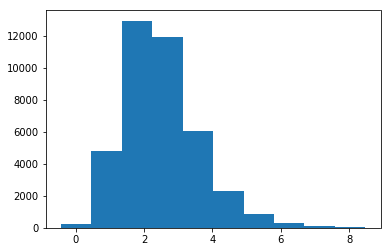

In [288]:
plt.hist(preds)

Теперь как раз применяем `CountVectorizer`. 

Будем смотреть на качество (MAE) на 30% данных, причем не перемешиваем данные, а соблюдаем время – проверочная часть четко по времени после обучающей.

Записываем прогнозы в файл. 

In [286]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA,
                                        'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [287]:
write_submission_file(preds, 
                      os.path.join(PATH_TO_DATA, 'first_my.csv'))

Если сделать посылку на [сайте](https://mlcourse.arktur.io/dashboard?problem=MLCourse) соревнования, то получится воспроизведение бенчмарка "Content only, Ridge + CountVectorizer".